### This notebook calculates the predicted and observed $C^{\kappa \kappa}_{l}$ from CCL and healpy (Planck map) respectively, and compares the values.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import pyccl as ccl
import pymaster as nmt

Binning function from Sukhdeep

In [2]:
import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

### $C^{\kappa \kappa}_{l}$ from theory (CCL)

In [3]:
#define cosmology
cosmo = ccl.Cosmology(Omega_c = 0.268, Omega_b = 0.049, \
        h = 0.67, n_s = 0.964, A_s=2.119e-9, \
        Neff=3.0, m_nu=np.array([0, 0, 0.06]), Omega_k=0) #Planck 2018 CMB Lensing Fiducial

In [4]:
#calculate theoretical Cls
lmax = 1500
ell = np.arange(0, lmax, 1) #lmax = 1500
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

/home/tanveer/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


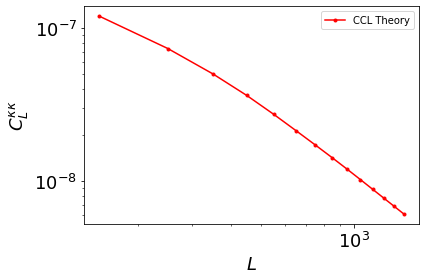

In [5]:
fs = 18

#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, cls_cmb, ELL)

fltr = (tmp[0] > 100)
ELL_th = tmp[0][fltr]
cLkk_th = tmp[1][fltr]

plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkk_th, 'r.-', label = 'CCL Theory')
plt.legend(loc = 'best')
plt.show()

### $C^{\kappa \kappa}_{l}$ from experiment

Import Planck noise model $n^{\kappa \kappa}_{l}$

In [7]:
#cols: 0 = Cl, 1 = nlkk, 2 = clkk + nlkk
nlkk_planck = np.genfromtxt("data/MV/nlkk.dat")
fltr = (nlkk_planck[:,0] >= 100) & (nlkk_planck[:,0] <= lmax)

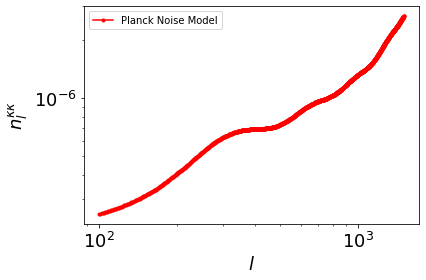

In [8]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$n^{\kappa \kappa}_{l}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(nlkk_planck[:,0][fltr], nlkk_planck[:,1][fltr], 'r.-', label = 'Planck Noise Model')
plt.legend(loc = 'best')
plt.show()

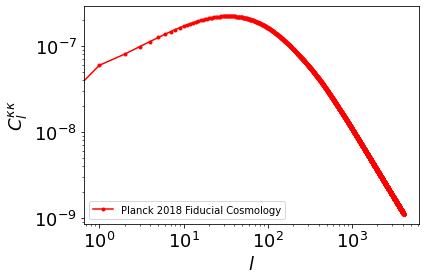

In [9]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{l}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
plt.plot(nlkk_planck[:,0], nlkk_planck[:,2] - nlkk_planck[:,1], 'r.-', label = 'Planck 2018 Fiducial Cosmology')
plt.legend(loc = 'best')
plt.show()

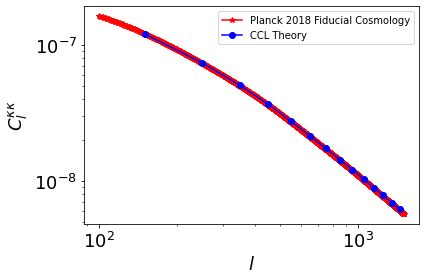

In [10]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{l}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')

plt.plot(nlkk_planck[:,0][fltr], \
         (nlkk_planck[:,2] - nlkk_planck[:,1])[fltr],\
         'r*-', label = 'Planck 2018 Fiducial Cosmology')
plt.plot(ELL_th, cLkk_th, 'bo-', label = 'CCL Theory')
plt.legend(loc = 'best')

In [11]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(nlkk_planck[:,0][fltr], (nlkk_planck[:,2] - nlkk_planck[:,1])[fltr], ELL)

fltr = (tmp[0] > 100)
ELL_planck_fiducial = tmp[0][fltr]
cLkk_planck_fiducial = tmp[1][fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


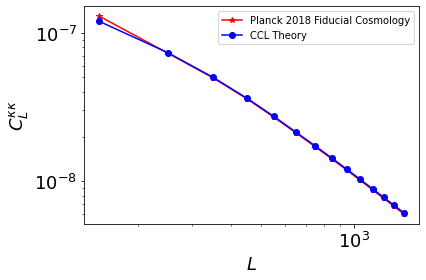

In [12]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')

plt.plot(ELL_planck_fiducial, cLkk_planck_fiducial, 'r*-', label = 'Planck 2018 Fiducial Cosmology')
plt.plot(ELL_th, cLkk_th, 'bo-', label = 'CCL Theory')
plt.legend(loc = 'best')

**Conclusion: Theoretical $C^{\kappa \kappa}_{l}$ from CCL matches Planck 2018 Fiducial Cosmology well.**

Read in CMB lensing map

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


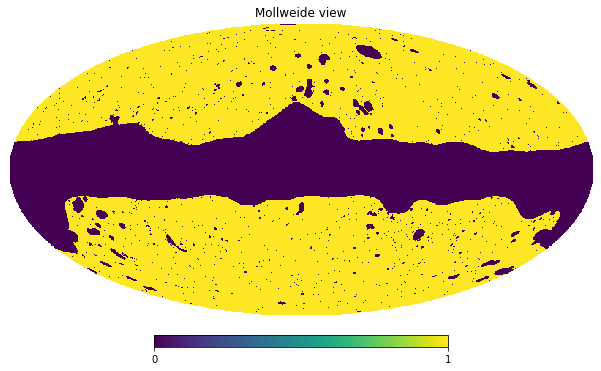

In [13]:
lensingMask_planck = hp.fitsfunc.read_map("data/mask.fits")
lensing_mask_bool_planck = lensingMask_planck
hp.mollview(lensingMask_planck)

Read in $a_{lm}$ values from the Planck lensing file; apply $0^{\circ}$ Gaussian smoothing

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


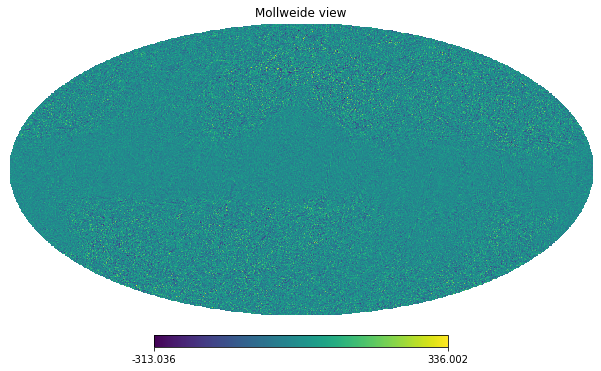

In [14]:
#read in a_lm 
#According to https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing#2018_Lensing_maps,
#planck lensing map values are given in terms of a_lm
almLensing_planck = hp.fitsfunc.read_alm("data/MV/dat_klm.fits")
lensingMap_planck = hp.sphtfunc.alm2map(almLensing_planck, \
                    nside = 2048, sigma=np.deg2rad(0)) #nside value comes from https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing#2018_Lensing_maps
hp.mollview(lensingMap_planck)

In [15]:
hp.mask_bad(lensingMap_planck).sum()

0

We can see the galactic mask in the lensing map produced from $a_{lm}$ values. Now we need to check whether number of masked pixels from $a_{lm}$ matches the boolean mask.

As none of the pixels are *masked*, we need to use the mask to calculate $C_l$

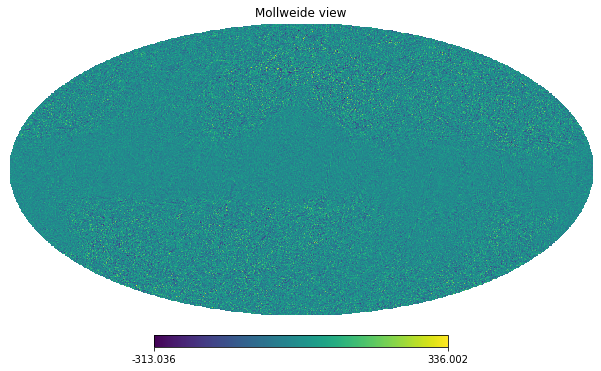

In [16]:
#set mask value to badval
lensingMap_planck_masked = np.copy(lensingMap_planck)
#lensingMap_planck_masked[lensing_mask_bool_planck == 0] = hp.UNSEEN
hp.mollview(lensingMap_planck_masked)

In [17]:
lensingMap_planck_masked = hp.ma(lensingMap_planck_masked, badval = 0)
lensingMap_planck_masked.mask = np.logical_not(lensing_mask_bool_planck)

In [18]:
lensingMap_planck_masked

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=0.0)

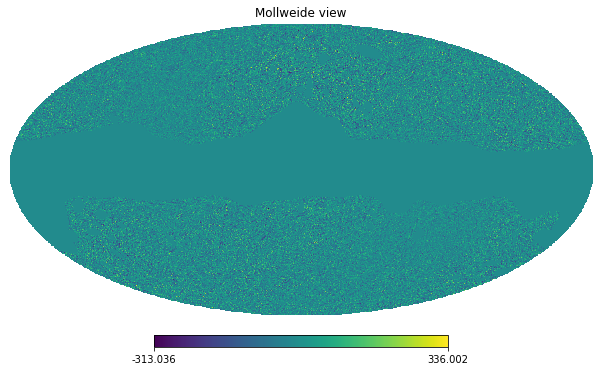

In [19]:
hp.mollview(lensingMap_planck_masked)

Calculate $C^{\kappa \kappa}_{l}$ from $a_{lm}$

In [44]:
clkk_planck_alm = hp.sphtfunc.alm2cl(almLensing_planck, lmax_out=lmax)
ell = np.arange(0, lmax+1, 1)

In [45]:
clkk_planck_alm /= nlkk_planck[:,1][nlkk_planck[:,0] <= 1500]

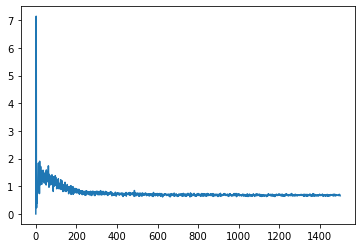

In [46]:
plt.plot(clkk_planck_alm)

Compare $C_{l}^{\kappa \kappa}$ with $C_l$ from `nlkk.dat`

In [47]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, clkk_planck_alm, ELL)

fltr = (tmp[0] > 100)
ELL_planck_alm = tmp[0][fltr]
cLkk_planck_alm = tmp[1][fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


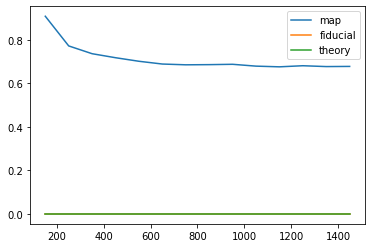

In [50]:
plt.plot(ELL_planck_alm, cLkk_planck_alm, label = 'map')
plt.plot(ELL_planck_fiducial, cLkk_planck_fiducial, label = 'fiducial')
plt.plot(ELL_th, cLkk_th, label = 'theory')
plt.legend(loc = 'best')

Calculate $C^{\kappa \kappa}_{l}$ from map directly

In [38]:
clkk_planck_map = hp.anafast(lensingMap_planck_masked, lmax=lmax)

Compare $C^{\kappa \kappa}_{l}$ from the two different methods

In [39]:
#Calculate fsky to correctly normalize Cl
fsky_lensing = lensing_mask_bool_planck.sum()/lensing_mask_bool_planck.size
fsky_lensing

0.670629620552063

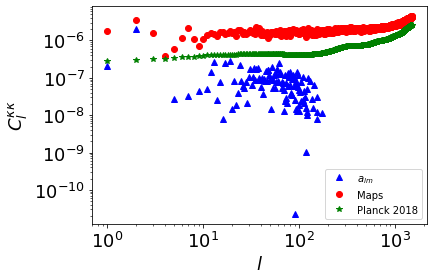

In [42]:
fltr = (nlkk_planck[:,0] <= lmax)

plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{l}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')

plt.plot(ell, clkk_planck_alm/fsky_lensing, "b^", label = r"$a_{lm}$")
plt.plot(ell, clkk_planck_map/fsky_lensing, "ro", label = "Maps")
plt.plot(nlkk_planck[:,0][fltr], nlkk_planck[:,2][fltr], "g*", label = "Planck 2018")
plt.legend(loc = 'best')

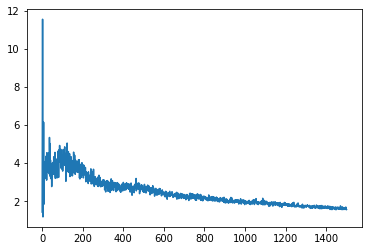

In [43]:
plt.plot(ell, (clkk_planck_map/fsky_lensing)/nlkk_planck[:,2][fltr])

For some reason, $C_l$ from masked map is way off compared to that from $a_{lm}$

Remove monopole and dipole and repeat the experiment

monopole: -0.000129163  dipole: lon: -106.619, lat: -47.0913, amp: 0.000918145


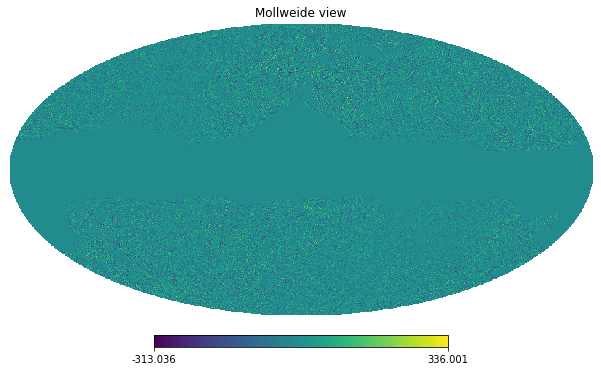

In [24]:
hp.mollview(hp.remove_dipole(lensingMap_planck_masked))

In [25]:
tmp22 = hp.anafast(hp.remove_dipole(lensingMap_planck_masked), lmax=lmax)

monopole: -0.000129163  dipole: lon: -106.619, lat: -47.0913, amp: 0.000918145


(1e-07, 1e-05)

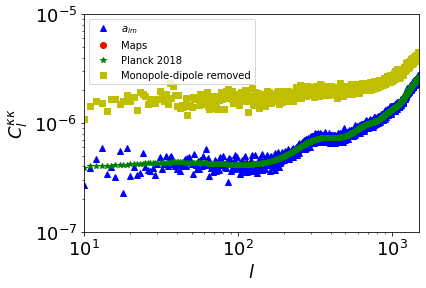

In [26]:
fltr = (nlkk_planck[:,0] <= lmax)

plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{l}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.xscale('log')

plt.plot(ell, clkk_planck_alm/fsky_lensing, "b^", label = r"$a_{lm}$")
plt.plot(ell, clkk_planck_map/fsky_lensing, "ro", label = "Maps")
plt.plot(nlkk_planck[:,0][fltr], nlkk_planck[:,2][fltr], "g*", label = "Planck 2018")
plt.plot(ell, tmp22/fsky_lensing, "ys", label = "Monopole-dipole removed")
plt.legend(loc = 'best')
plt.xlim(10, 1500)
plt.ylim(1e-7,1e-5)

**Conclusion: $C_l$ directly from map is really off. I tried different Gaussian smoothing kernels and the power spectrum fluctuates widely. I am a little unsure as to what is causing this.**

Plot Planck 2018 Fiducial values with observed $C_l$s

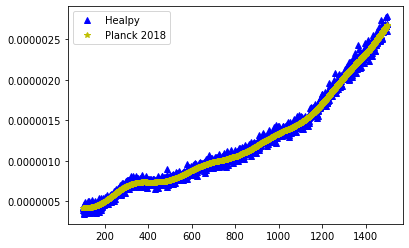

In [27]:
fltr_nlkk = (nlkk_planck[:,0] >= 100) & (nlkk_planck[:,0] <= lmax) #only show C_l in 100 <= l <= 1500 range
plt.plot(ell[(ell >= 100) & (ell <= lmax)], clkk_planck_alm[(ell >= 100) & (ell <= lmax)]/fsky_lensing, \
         "b^", label = r"Healpy")
plt.plot(nlkk_planck[:,0][fltr_nlkk], nlkk_planck[:,2][fltr_nlkk], "y*", label = "Planck 2018")
plt.legend(loc = 'best')

Text(0, 0.5, 'Planck 2018')

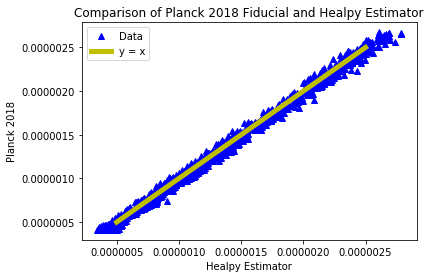

In [28]:
plt.plot(clkk_planck_alm[(ell >= 100) & (ell <= lmax)]/fsky_lensing, nlkk_planck[:,2][fltr_nlkk],\
         "b^", label = "Data")
plt.title("Comparison of Planck 2018 Fiducial and Healpy Estimator")
tmpx = np.arange(.0000005, .0000025, .0000005)
plt.plot(tmpx, tmpx, "y-", lw = 5, label = "y = x")
plt.legend(loc = 'best')
plt.xlabel("Healpy Estimator")
plt.ylabel("Planck 2018")

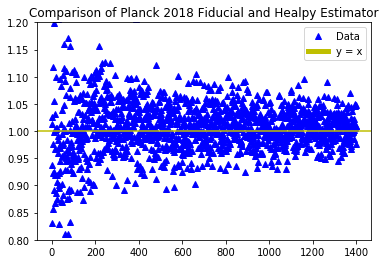

In [42]:
plt.plot((clkk_planck_alm[(ell >= 100) & (ell <= lmax)]/fsky_lensing)/nlkk_planck[:,2][fltr_nlkk],\
         "b^", label = "Data")
plt.title("Comparison of Planck 2018 Fiducial and Healpy Estimator")
tmpx = np.arange(.0000005, .0000025, .0000005)
plt.plot(tmpx, tmpx, "y-", lw = 5, label = "y = x")
plt.legend(loc = 'best')
#plt.xlabel("Healpy Estimator")
#plt.ylabel("Planck 2018")
plt.ylim(.8, 1.2)
plt.axhline(1, c = "y")

In [59]:
np.mean((clkk_planck_alm[(ell >= 100) & (ell <= lmax)]/fsky_lensing)/nlkk_planck[:,2][fltr_nlkk])

1.0072354146830633

In [51]:
#binned Cls by L = 100l
alm_binned = bin_mat(ell[fltr_ell], \
    (clkk_planck_alm[(ell >= 100) & (ell <= lmax)]/fsky_lensing), ELL)

alm_ELL = alm_binned[0]
alm_observed = alm_binned[1]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [53]:
#binned Cls by L = 100l
planck_binned = bin_mat(nlkk_planck[:,0][fltr_nlkk], nlkk_planck[:,2][fltr_nlkk], ELL)

planck_ELL = planck_binned[0]
planck_observed = planck_binned[1]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [57]:
np.mean(alm_observed/planck_observed)

1.0073418283749282

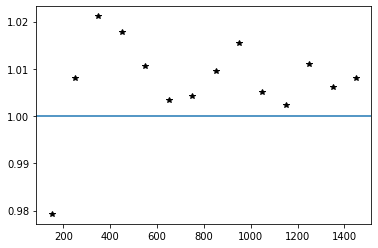

In [55]:
plt.plot(alm_ELL, alm_observed/planck_observed, "k*", label = "alm")
plt.axhline(1)

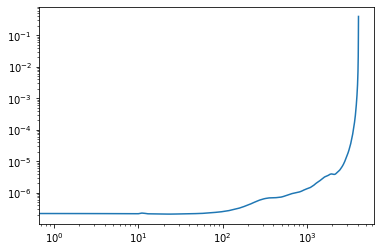

In [44]:
plt.loglog(nlkk_planck[:,0], nlkk_planck[:,1])

Looks like observed estimator values and Planck 2018 are in strong agreement.

Now, subtract $n^{\kappa \kappa}_{l}$ to get pure $C_l$

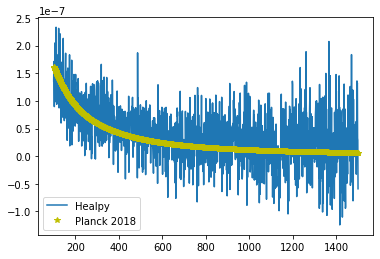

In [29]:
fltr_ell = (ell >= 100) & (ell <= lmax) #100 <= l <= 1500
plt.plot(ell[fltr_ell], \
         ((clkk_planck_alm[fltr_ell]/fsky_lensing) - nlkk_planck[:,1][fltr_nlkk]), \
        label = "Healpy")
plt.plot(nlkk_planck[:,0][fltr_nlkk], \
         nlkk_planck[:,2][fltr_nlkk] - nlkk_planck[:,1][fltr_nlkk], "y*", label = "Planck 2018")
plt.legend(loc = 'best')

**Conclusion: It is interesting that once the error is subtracted, the estimator values look much *noisier* than the Planck 2018 Fiducial one**

Bin estimator values to compare with theory 

In [30]:
ELL = np.arange(100, lmax+1, 100)

In [31]:
nlkk_planck.shape

(4097, 3)

In [32]:
#binned Cls by L = 100l
tmp = bin_mat(ell[fltr_ell], \
    ((clkk_planck_alm[fltr_ell]/fsky_lensing) - nlkk_planck[:,1][fltr_nlkk]), ELL)

ELL_planck_observed = tmp[0]
cLkk_planck_observed = tmp[1]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


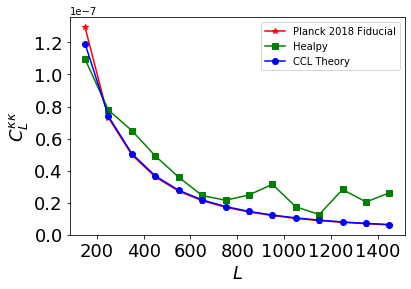

In [37]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
#plt.yscale('log')
#plt.xscale('log')

plt.plot(ELL_planck_fiducial, cLkk_planck_fiducial, 'r*-', label = 'Planck 2018 Fiducial')
plt.plot(ELL_planck_observed, cLkk_planck_observed, 'gs-', label = 'Healpy')
plt.plot(ELL_th, cLkk_th, 'bo-', label = 'CCL Theory')
plt.legend(loc = 'best')
plt.savefig("results/cLkk.pdf")

In [34]:
cLkk_planck_observed

array([1.09570780e-07, 7.77439724e-08, 6.49371566e-08, 4.91351904e-08,
       3.58260274e-08, 2.44205598e-08, 2.14509571e-08, 2.47131622e-08,
       3.13950750e-08, 1.73765542e-08, 1.25235619e-08, 2.81682990e-08,
       2.03681766e-08, 2.60788196e-08])

In [35]:
np.mean(cLkk_th/cLkk_planck_observed)

0.6566541190592059

In [36]:
cLkk_th

array([1.19256345e-07, 7.38599927e-08, 5.05467125e-08, 3.66634054e-08,
       2.76719092e-08, 2.16574013e-08, 1.74969418e-08, 1.44786753e-08,
       1.21917767e-08, 1.04140193e-08, 9.01282088e-09, 7.89329716e-09,
       6.98365101e-09, 6.23169399e-09])

**Conclusion: Healpy based estimator is systematically higher-valued than theory and Planck 2018 Fiducial.**

### The following section is not useful right now because *NaMaster* relies on the map and mask and since the map $C_l$s from *Healpy* is incorrect, I will not attempt until the problem is figured out.

Calculate $C_l$ with NaMaster

In [30]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_0 = nmt.NmtField(lensing_mask_bool_planck, [lensingMap_planck])

# Initialize binning scheme with 100 ells per bandpower
b = nmt.NmtBin.from_nside_linear(hp.get_nside(lensingMap_planck), 100)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

KeyboardInterrupt: 

Get binned $L$ values from NaMaster

In [ ]:
ell_effective = b.get_effective_ells()

In [ ]:
fltr = (ell_effective >= 100) & (ell_effective <= 1500)
plt.plot(ell_effective[fltr], cl_00[0][fltr], 'bo')

Check $C_l$s from different methods

In [ ]:
plt.plot(ell_effective[fltr], cl_00[0][fltr], 'bo', label = "NaMaster Binned")
#plt.plot(ell, clkk_planck_map, label = "Healpy Map")
#plt.plot(ell, clkk_planck_alm, label = r"Healpy $a_{lm}$")
plt.legend(loc = 'best')
plt.xlabel(r"$l$")
plt.ylabel(r"$C^{\kappa \kappa}_{l}$")

In [ ]:
#read in a_lm 
#According to https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing#2018_Lensing_maps,
#planck lensing map values are given in terms of a_lm
lensingMap_planck2 = hp.sphtfunc.alm2map(almLensing_planck, \
                    nside = 2048) #nside value comes from https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Lensing#2018_Lensing_maps
hp.mollview(lensingMap_planck2)

In [ ]:
#set mask value to badval
lensingMap_planck_masked2 = np.copy(lensingMap_planck2)
lensingMap_planck_masked2[lensing_mask_bool_planck == 0] = hp.UNSEEN
hp.mollview(lensingMap_planck_masked2)

In [ ]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_0 = nmt.NmtField(lensing_mask_bool_planck, [lensingMap_planck2])

# Initialize binning scheme with 100 ells per bandpower
b = nmt.NmtBin.from_nside_linear(hp.get_nside(lensingMap_planck2), 100)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

In [ ]:
ell_effective = b.get_effective_ells()
fltr = (ell_effective >= 100) & (ell_effective <= 1500)
plt.plot(ell_effective[fltr], cl_00[0][fltr], 'bo')

In [71]:
ell_effective

array([  51.5,  151.5,  251.5,  351.5,  451.5,  551.5,  651.5,  751.5,
        851.5,  951.5, 1051.5, 1151.5, 1251.5, 1351.5, 1451.5, 1551.5,
       1651.5, 1751.5, 1851.5, 1951.5, 2051.5, 2151.5, 2251.5, 2351.5,
       2451.5, 2551.5, 2651.5, 2751.5, 2851.5, 2951.5, 3051.5, 3151.5,
       3251.5, 3351.5, 3451.5, 3551.5, 3651.5, 3751.5, 3851.5, 3951.5,
       4051.5, 4151.5, 4251.5, 4351.5, 4451.5, 4551.5, 4651.5, 4751.5,
       4851.5, 4951.5, 5051.5, 5151.5, 5251.5, 5351.5, 5451.5, 5551.5,
       5651.5, 5751.5, 5851.5, 5951.5, 6051.5])

In [75]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(nlkk_planck[:,0], nlkk_planck[:,1], ELL)

#fltr = (tmp[0] > 100)
ELL_nlkk = tmp[0]#[fltr]
nLkk = tmp[1]#[fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [77]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(nlkk_planck[:,0], nlkk_planck[:,2], ELL)

#fltr = (tmp[0] > 100)
ELL_nlkk_clkk = tmp[0]#[fltr]
nLkk_cLkk = tmp[1]#[fltr]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


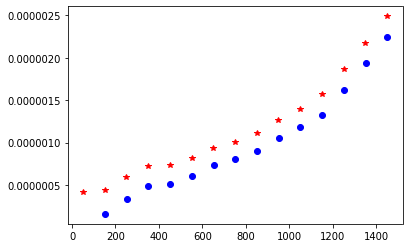

In [82]:
plt.plot(ELL_nlkk_clkk, nLkk_cLkk, 'r*')
plt.plot(ell_effective[fltr], cl_00[0][fltr], 'bo')

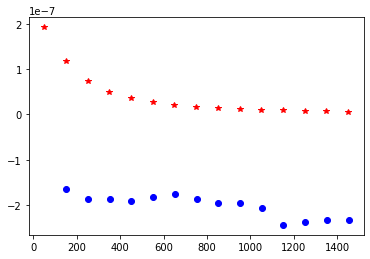

In [88]:
plt.plot(ell_effective[fltr], cl_00[0][fltr] - nLkk[1:], 'bo')
plt.plot(ELL_nlkk_clkk, nLkk_cLkk - nLkk, 'r*')

In [84]:
ELL_nlkk

array([  50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,
        950., 1050., 1150., 1250., 1350., 1450.])

In [86]:
ell_effective[fltr]

array([ 151.5,  251.5,  351.5,  451.5,  551.5,  651.5,  751.5,  851.5,
        951.5, 1051.5, 1151.5, 1251.5, 1351.5, 1451.5])